# **RECOMMENDER SYSTEM - ANIME MOVIES & SERIES**

### **Deskripsi**: Membuat sistem rekomendasi konten movie & series anime menggunakan Content Based Filtering

In [2]:
!pip install opendatasets
!pip install pandas

     -------------------------------------- 59.0/59.0 kB 447.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73031 sha256=6d63a5e7f454deead1b5efa390f72364f88f97ed8087ff02c861be84b890909d
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\ac\b2\c3\fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


**Import Library yang dibutuhkan**

In [6]:
import pandas as pd
import opendatasets as od
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

**Install Dataset melalui Kaggle Repositories**

In [7]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download -d CooperUnion/anime-recommendations-database
od.download(
    "https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database"
    )

100%|██████████| 25.0M/25.0M [00:11<00:00, 2.35MB/s]


Unzip dataset

In [10]:
#! unzip anime-recommendations-database.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


Mendefinisikan dataset CSV dan listing genre

In [12]:
anime = pd.read_csv('anime.csv')

values = ['Drama', 'Romance', 'Adventure', 'Action', 'SciFi', 'Fantasy', 'Comedy', 'Slice of Life', 'Sports', 'Horror', 'Supernatural', 'Mystery', 'Historical']
animes = anime[anime.genre.isin(values) == True]
animes.sample(3)


,anime_id,name,genre,type,episodes,rating,members
9517,25267,Megumi to Taiyou II: Kajuu Gummi Tweet Mystery...,Mystery,Special,1,4.94,154
6134,9846,Attraction,Mystery,ONA,1,6.24,1430
9801,27573,Obasuteyama,Drama,Movie,1,7.00,57


In [13]:
anime.head(3)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262


In [15]:
animes.head(3)

,anime_id,name,genre,type,episodes,rating,members
244,5365,Tsumiki no Ie,Drama,Movie,1,8.27,45189
321,6211,Tokyo Magnitude 8.0,Drama,TV,11,8.19,121349
415,7711,Karigurashi no Arrietty,Fantasy,Movie,1,8.10,97910


In [14]:
ratings = pd.read_csv('rating.csv')
ratings.sample(3)

,user_id,anime_id,rating
6531346,60338,8277,7
2853705,26685,3702,8
4764514,45472,1498,6


**Deskripsi Dataset**

**Memperoleh informasi mengenai dataset 'anime.csv' dan 'ratings.csv'**

Mengetahui jumlah baris dan kolom pada data

In [16]:
animes.shape

(1156, 7)

In [17]:
ratings.shape

(7813737, 3)

In [18]:
animes.info

<bound method DataFrame.info of        anime_id                                               name    genre  \
244        5365                                      Tsumiki no Ie    Drama   
321        6211                                Tokyo Magnitude 8.0    Drama   
415        7711                            Karigurashi no Arrietty  Fantasy   
469       29093              Grisaia no Meikyuu: Caprice no Mayu 0    Drama   
707        1520                                         Black Jack    Drama   
...         ...                                                ...      ...   
11062     34348                                    Rescue Academia    Drama   
11066     34494                                       Sakura Quest   Comedy   
11074     34456                         Sentai Hero Sukiyaki Force   Comedy   
11093     21305                                     Trick or Alice  Fantasy   
11098     34498  Uchiage Hanabi, Shita kara Miru ka? Yoko kara ...    Drama   

          type epis

In [19]:
ratings.info

<bound method DataFrame.info of          user_id  anime_id  rating
0              1        20      -1
1              1        24      -1
2              1        79      -1
3              1       226      -1
4              1       241      -1
...          ...       ...     ...
7813732    73515     16512       7
7813733    73515     17187       9
7813734    73515     22145      10
7813735    73516       790       9
7813736    73516      8074       9

[7813737 rows x 3 columns]>

Mengetahui rentang nilai rating pada data

In [20]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Menghitung jumlah/overall masing - masing konten anime dan genre

In [21]:
print('Jumlah Anime: ', len(animes.anime_id.unique()))
print('Jumlah Genre: ', len(animes.genre.unique()))

Jumlah Anime:  1156
Jumlah Genre:  12


Memperoleh jenis genre dan tipe penayangan konten anime

In [22]:
print('Genre: ', animes.genre.unique())
print('Types: ', animes.type.unique())

Genre:  ['Drama' 'Fantasy' 'Comedy' 'Action' 'Mystery' 'Adventure' 'Sports'
 'Slice of Life' 'Romance' 'Historical' 'Horror' 'Supernatural']
Types:  ['Movie' 'TV' 'Special' 'OVA' 'ONA' nan]


**Exploratory Data Analysis**

Visualisasi data, untuk mengetahui porsi jumlah masing - masing genre terhadap keseluruhan data

In [23]:
categorical_features = ['genre']
feature = categorical_features[0]
count = animes[feature].value_counts()
percent = 100*animes[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah Anime':count, 'Persentase':percent.round(1)})
print(df)

               jumlah Anime  Persentase
Comedy                  523        45.2
Fantasy                 114         9.9
Drama                   107         9.3
Slice of Life            99         8.6
Adventure                79         6.8
Historical               68         5.9
Action                   53         4.6
Sports                   44         3.8
Horror                   21         1.8
Mystery                  19         1.6
Romance                  15         1.3
Supernatural             14         1.2


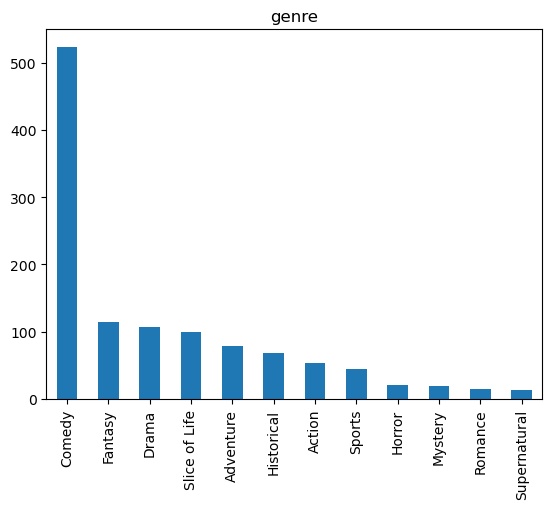

In [24]:
count.plot(kind='bar', title=feature);

Menghitung jumlah user ID dan data rating berdasarkan raw dataset saat ini

In [25]:
print('Jumlah User: ', len(ratings.user_id.unique()))
print('Jumlah rating: ', len(ratings))

Jumlah User:  73515
Jumlah rating:  7813737


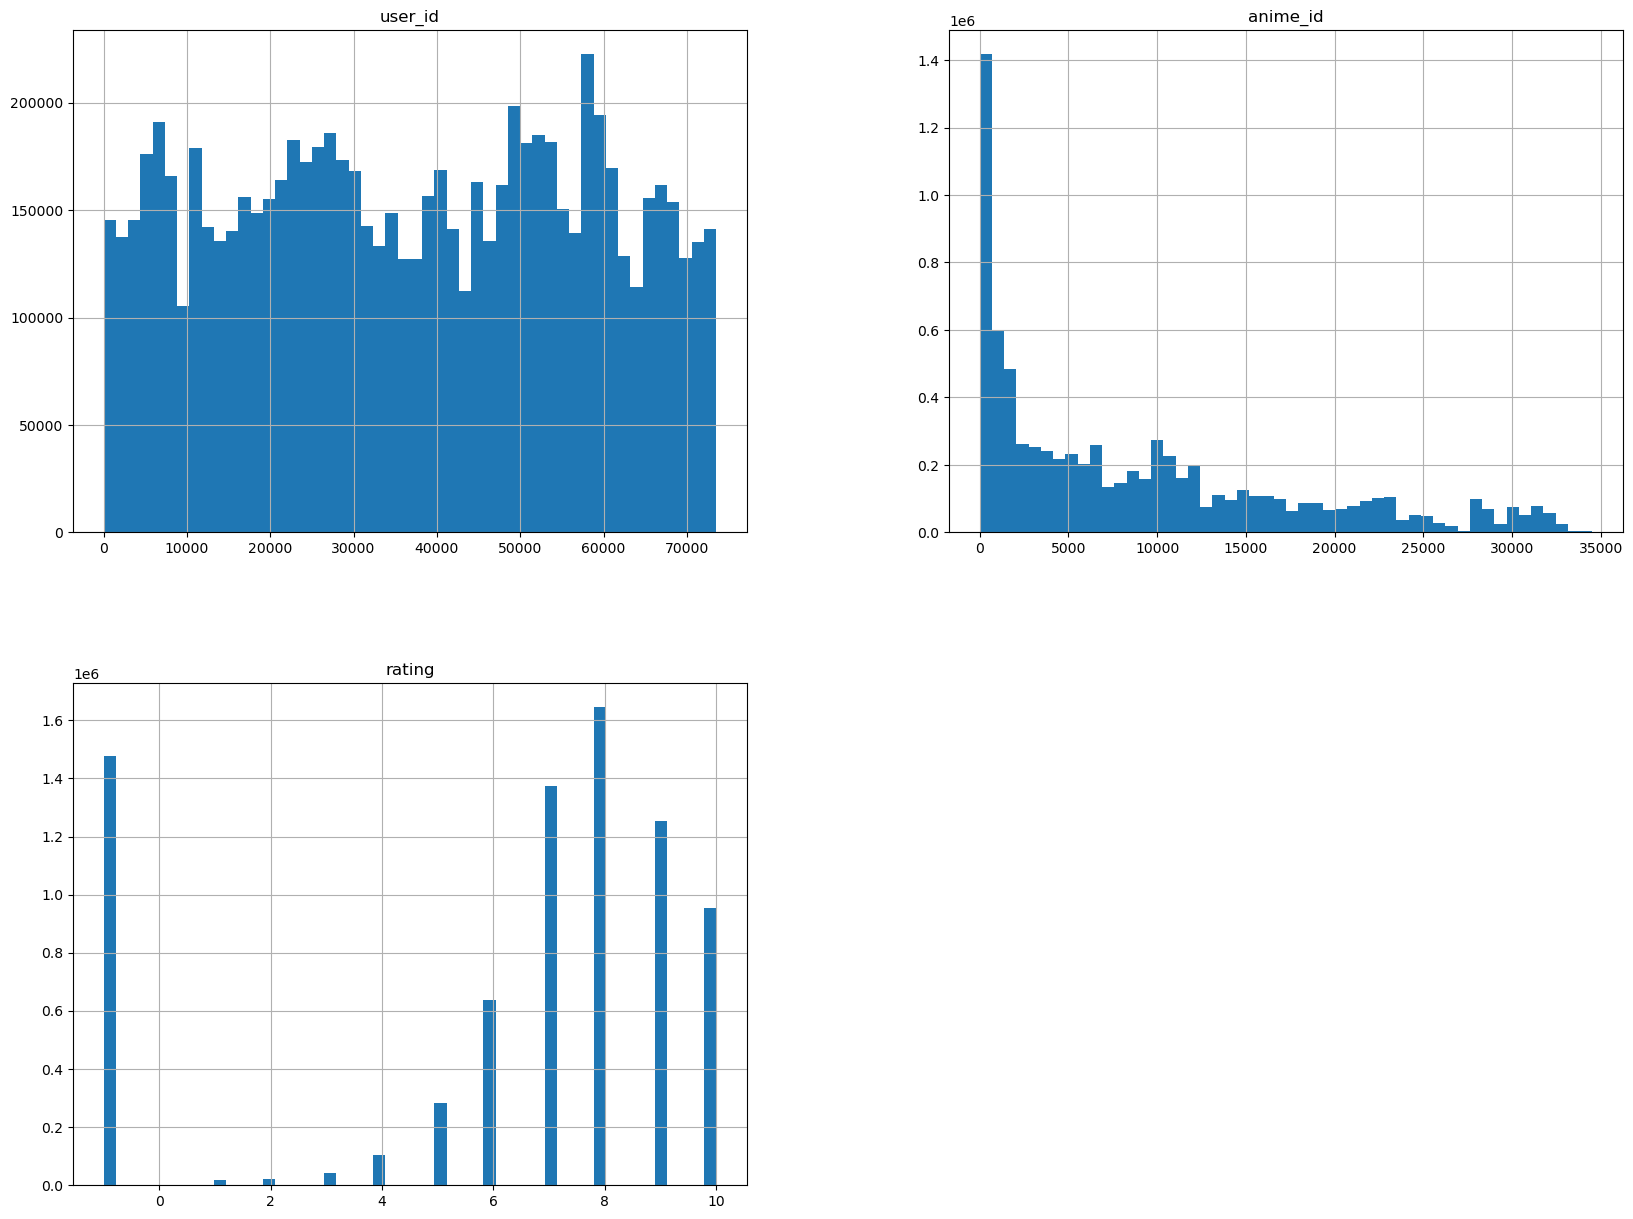

In [26]:
ratings.hist(bins=50, figsize=(20,15))
plt.show()

**Data Preparation**

**Menggabungkan data anime_id pada dataset 'anime' dan 'ratings' untuk memperoleh info jumlah aktual pada fitur anime_id**

In [27]:
animes_allid = np.concatenate((
    animes.anime_id.unique(),
    ratings.anime_id.unique(),
))
 
animes_allid = np.sort(np.unique(animes_allid))
 
print('Jumlah seluruh data id berdasarkan anime_id: ', len(animes_allid))


Jumlah seluruh data id berdasarkan anime_id:  11363


**Menggabungkan data rating pada dataset 'anime' dan 'ratings' untuk memperoleh info jumlah aktual pada fitur rating**

In [28]:
animes_allrate = np.concatenate((
    animes.rating.unique(),
    ratings.rating.unique(),
))
 
# Mengurutkan data
animes_allrate = np.sort(np.unique(animes_allrate))
 
print('Jumlah seluruh data rating berdasarkan anime_id: ', len(animes_allrate))

Jumlah seluruh data rating berdasarkan anime_id:  380


Memeriksa apakah terdapat data yang kosong atau 'NaN' pada data

In [29]:
animes.isnull().sum()

anime_id     0
name         0
genre        0
type         2
episodes     0
rating      13
members      0
dtype: int64

**Menghapus data yang kosong atau 'NaN'**

In [30]:
animes_fix = animes.dropna()
animes_fix

,anime_id,name,genre,type,episodes,rating,members
244,5365,Tsumiki no Ie,Drama,Movie,1,8.27,45189
321,6211,Tokyo Magnitude 8.0,Drama,TV,11,8.19,121349
415,7711,Karigurashi no Arrietty,Fantasy,Movie,1,8.10,97910
469,29093,Grisaia no Meikyuu: Caprice no Mayu 0,Drama,Special,1,8.05,70039
707,1520,Black Jack,Drama,OVA,12,7.88,14414
...,...,...,...,...,...,...,...
10885,12759,Zoku Zoku Mura no Obaketachi,Fantasy,OVA,12,6.33,76
10888,30090,Zombie Ehon,Comedy,ONA,1,3.54,86
10890,11097,Zou no Inai Doubutsuen,Drama,Movie,1,6.07,85
10891,11095,Zouressha ga Yatte Kita,Adventure,Movie,1,6.06,78


**Sorting data/mengurutkan data dari angka terkecil fitur anime_id**

In [31]:
animes_fixed = animes_fix.sort_values('anime_id', ascending=True)
animes_fixed

,anime_id,name,genre,type,episodes,rating,members
1809,485,Damekko Doubutsu,Comedy,TV,26,7.43,8024
3254,580,Kogepan,Comedy,TV,10,7.04,4436
3174,673,Mai-HiME Specials,Comedy,Special,27,7.06,9210
6161,748,True Love Story,Romance,OVA,3,6.24,3409
6833,983,Cosplay Complex: Extra Identification,Comedy,OVA,1,5.90,2145
...,...,...,...,...,...,...,...
7459,34324,Chiryokumaru,Action,ONA,1,5.40,817
10662,34453,Uma Musume: Pretty Derby,Action,ONA,1,6.64,75
10444,34490,Sushi Azarashi,Comedy,TV,30,3.00,12
9266,34503,Kochinpa! Dainiki,Comedy,TV,24,3.40,75


In [32]:
print('Jumlah anime_id: ', len(animes_fixed.anime_id.unique())) 
print('Jumlah genre: ', len(animes_fixed.genre.unique()))

Jumlah anime_id:  1143
Jumlah genre:  12


**Drop value yang memiliki data duplikat pada dataset yang telah diolah sebelumnya**

In [33]:
preparation = animes_fixed.drop_duplicates('anime_id')
preparation

,anime_id,name,genre,type,episodes,rating,members
1809,485,Damekko Doubutsu,Comedy,TV,26,7.43,8024
3254,580,Kogepan,Comedy,TV,10,7.04,4436
3174,673,Mai-HiME Specials,Comedy,Special,27,7.06,9210
6161,748,True Love Story,Romance,OVA,3,6.24,3409
6833,983,Cosplay Complex: Extra Identification,Comedy,OVA,1,5.90,2145
...,...,...,...,...,...,...,...
7459,34324,Chiryokumaru,Action,ONA,1,5.40,817
10662,34453,Uma Musume: Pretty Derby,Action,ONA,1,6.64,75
10444,34490,Sushi Azarashi,Comedy,TV,30,3.00,12
9266,34503,Kochinpa! Dainiki,Comedy,TV,24,3.40,75


**Melaukan konversi data pada masing - masing fitur menjadi format/bentuk list**

In [34]:
# Mengonversi data series 'animeID'
animeID = preparation['anime_id'].tolist()
 
# Mengonversi data series ‘title’ 
title = preparation['name'].tolist()
 
# Mengonversi data series ‘genres’
genres = preparation['genre'].tolist()
 
print(len(animeID))
print(len(title))
print(len(genres))

1143
1143
1143


**Membuat data dictionary**

In [35]:
anime_new = pd.DataFrame({
    'id': animeID,
    'titles': title,
    'genre': genres
})
anime_new     

,id,titles,genre
0,485,Damekko Doubutsu,Comedy
1,580,Kogepan,Comedy
2,673,Mai-HiME Specials,Comedy
3,748,True Love Story,Romance
4,983,Cosplay Complex: Extra Identification,Comedy
...,...,...,...
1138,34324,Chiryokumaru,Action
1139,34453,Uma Musume: Pretty Derby,Action
1140,34490,Sushi Azarashi,Comedy
1141,34503,Kochinpa! Dainiki,Comedy


In [36]:
# Melihat sampel data
data = anime_new
data.sample(5)

,id,titles,genre
634,17092,Dallyeola Hani,Sports
659,18133,Ikeike! Momon-chan,Comedy
75,3267,Kingdom of Chaos: Born to Kill,Fantasy
867,29756,Sinbad: Soratobu Hime to Himitsu no Shima,Adventure
585,13553,Bakusou Circuit Roman Twin,Sports


**Modelling**

**Inisialisasi TfidfVectorizer, melakukan perhitungan idf dan mapping array**

In [37]:
tf = TfidfVectorizer()
 
tf.fit(data['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names() 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'comedy',
 'drama',
 'fantasy',
 'historical',
 'horror',
 'life',
 'mystery',
 'of',
 'romance',
 'slice',
 'sports',
 'supernatural']

**Melakukan fitment dan transformasi ke bentuk matrix**

In [38]:
tfidf_matrix = tf.fit_transform(data['genre']) 

# Melihat jumlah baris & data matrix tfidf
tfidf_matrix.shape 

(1143, 14)

Mengubah vektor Tfidf dalam bentuk matriks dengan fungsi todense

In [39]:
tfidf_matrix.todense()

matrix([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]])

Membuat dataframe dengan konten baris berisi fitur titles dan kolom berisi fitur genre

In [40]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names(),
    index=data.titles
).sample(12, axis=1).sample(10, axis=0)

,supernatural,horror,sports,historical,adventure,mystery,of,life,drama,fantasy,slice,comedy
titles,,,,,,,,,,,,
Hula Kappa,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,1.0
Kachikachi Yama (1940),0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,1.0,0.00000,0.0
KochinPa!,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,1.0
Sinbad: Mahou no Lamp to Ugoku Shima,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0
Kamisama Dolls Specials,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,1.0
Hanaori,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,1.0
Ore wa Chokkaku,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,1.0
Sylvanian Families Mini Gekijou: Omoigakenai Okyakusama,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.57735,0.0,0.0,0.57735,0.0
Hana no Hanashi,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.57735,0.0,0.0,0.57735,0.0


**Menghitung cosine similarity**

In [41]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Membuat dataframe dan meihat cosine similarity

In [42]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['titles'], columns=data['titles'])
print('Shape:', cosine_sim_df.shape)
 
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1143, 1143)


titles,Shuukan Shimakou Special,Senjou no Valkyria: SenVal Theater,Hitori de Nayamanaide Issho ni Kangaeyou,Asu wo Tsukutta Otoko: Tanabe Sakurou to Biwako Sosui,Utsurun Desu.
titles,,,,,
Forza! Hidemaru,0.0,0.0,0.0,0.0,0.0
Melody,0.0,0.0,1.0,0.0,0.0
Lovely Movie: Itoshi no Muco,0.0,0.0,0.0,0.0,0.0
Utsurun Desu.,1.0,1.0,0.0,0.0,1.0
Persona 3 the Movie Meets “Walkman”,0.0,0.0,1.0,0.0,0.0
Yuki no Yo no Yume,0.0,0.0,1.0,0.0,0.0
Rose O&#039;Neill Kewpie,1.0,1.0,0.0,0.0,1.0
Show By Rock!!: Plasmagica na Gogo,1.0,1.0,0.0,0.0,1.0
Nyanpuku Nyaruma,1.0,1.0,0.0,0.0,1.0


**Mengambil data dengan menggunakan argpartition**

In [43]:
def animes_recommendations(titles, similarity_data=cosine_sim_df, items=data[['titles', 'genre']], k=10): 
    # Dataframe -> numpy
    # Range start, stop, step
    index = similarity_data.loc[:,titles].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # drop titles agar nama konten yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(titles, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

**Result**

**Menguji model sistem rekomendasi**

In [44]:
titles = 'Wolf Daddy'
data[data.titles.eq(titles)]

,id,titles,genre
118,4099,Wolf Daddy,Fantasy


Hasil rekomendasi yang didapatkan

In [45]:
titles = 'Wolf Daddy'
animes_recommendations = animes_recommendations(titles)
animes_recommendations

,titles,genre
0,Shiawasette Naani,Fantasy
1,Escha &amp; Logy no Atelier: Tasogare no Sora ...,Fantasy
2,Lance N&#039; Masques,Fantasy
3,Fushigi na Elevator,Fantasy
4,Spectral Force Chronicle Divergence,Fantasy
5,Santa Company,Fantasy
6,Kudan,Fantasy
7,Hana to Shounen,Fantasy
8,Ukkari Pénélope OVA,Fantasy
9,"on-chan, Yume Power Daibouken!",Fantasy
